In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
uploaded = files.upload()

**1. IMPORTING TABLES**

In [ ]:
orders = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Orders")
returned = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Return")
segmentation = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Segmentation")
product = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Product")
location = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Location")
customer = pd.read_excel("/content/Dataset.xlsx", sheet_name = "Customer")

**2. CHECK INFO (no null value, correct datatype)**

In [ ]:
orders.info()
returned.info()
segmentation.info()
product.info()
location.info()
customer.info()

**3. REMOVE RETURNED ORDERS**

In [ ]:
merged_orders = orders.merge(returned, how = 'left', on = 'Order ID')
successful_orders = merged_orders[merged_orders['Returned'].isna()]

**4. RFM CALCULATION**

**4.1 Remove duplicated order ID**



In [ ]:
# Select dimension columns except for "Product ID"
dim_orders = successful_orders[['Customer ID','Order ID','Order Date','Ship Date','Ship Mode','Channel','Postal Code']].drop_duplicates()

# Select numeric columns
grouped_orders = successful_orders.groupby(['Customer ID','Order ID']).agg({'Sales':'sum','Quantity':'sum'})

# Merge to final
final_orders = dim_orders.merge(grouped_orders, how = 'left', on = ['Customer ID','Order ID'])
final_orders

,Customer ID,Order ID,Order Date,Ship Date,Ship Mode,Channel,Postal Code,Sales,Quantity
0,CC-12430,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,Home Office,47201,209.300,2
1,PO-18865,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,Consumer,10009,466.842,14
2,JM-15580,CA-2017-156720,2017-12-30,2018-01-03,Standard Class,Consumer,80538,3.024,3
3,JG-15160,CA-2017-118885,2017-12-29,2018-01-02,Standard Class,Consumer,90049,695.944,7
4,MC-17845,US-2017-102638,2017-12-29,2017-12-31,First Class,Consumer,10035,6.030,3
...,...,...,...,...,...,...,...,...,...
4708,JO-15145,CA-2014-106054,2014-01-06,2014-01-07,First Class,Corporate,30605,12.780,3
4709,ME-17320,CA-2014-167199,2014-01-06,2014-01-10,Standard Class,Home Office,42420,4374.880,24
4710,MB-18085,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,Consumer,19143,19.536,3
4711,PO-19195,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,Home Office,60540,288.060,8


 **4.2 Recency**

In [ ]:
# Adding most_recent_date column
final_orders['most_recent_date'] = final_orders.groupby(['Customer ID'])['Order Date'].transform('max')

# Adding 31/12/2017 date column
final_orders['now_date'] = pd.to_datetime('12/31/2017')

# Calculating recency
final_orders['recency'] = (final_orders['now_date'] - final_orders['most_recent_date']).dt.days

**4.3 Frequency**

In [ ]:
final_orders['frequency'] = final_orders.groupby(['Customer ID'])['Order ID'].transform('count')

**4.4 Monetory**

In [ ]:
final_orders['monetary'] = final_orders.groupby(['Customer ID'])['Sales'].transform('sum')

**4.5 Creating rfm table**

In [ ]:
rfm = final_orders[['Customer ID', 'recency', 'frequency', 'monetary']].drop_duplicates()
rfm = rfm.sort_values('Customer ID')
rfm

,Customer ID,recency,frequency,monetary
1018,AA-10315,185,5,5563.560
109,AA-10375,20,9,1056.390
1308,AA-10480,260,4,1790.512
2172,AA-10645,483,5,5073.975
1877,AB-10015,416,3,886.156
...,...,...,...,...
552,XP-21865,83,9,2110.726
20,YC-21895,5,4,5438.650
61,YS-21880,10,8,6720.444
397,ZC-21910,55,12,7892.998


**4.6 rfm score calculation**

In [ ]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 5, ['5','4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 5, ['1','2','3','4','5'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 5, ['1','2','3','4','5'])

In [ ]:
rfm['RFM Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm['RFM Score'] = rfm['RFM Score'].astype(np.int64)
rfm.head()

,Customer ID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM Score
1018,AA-10315,185,5,5563.560,2,2,5,225
109,AA-10375,20,9,1056.390,5,5,2,552
1308,AA-10480,260,4,1790.512,2,1,3,213
2172,AA-10645,483,5,5073.975,1,2,5,125
1877,AB-10015,416,3,886.156,1,1,2,112


**5. SEGMENTATION CLEANING**

In [ ]:
# Convert 'RFM Score' to list
segmentation['RFM Score'] = segmentation['RFM Score'].str.split(',')

# Explode 'RFM Score'
segmentation = segmentation.explode('RFM Score')

segmentation['RFM Score'] = segmentation['RFM Score'].astype(np.int64)
segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Segment    125 non-null    object
 1   RFM Score  125 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


**6. FINAL RFM TABLES**

In [ ]:
# Merge rfm vs segmenation
segmented_rfm = rfm.merge(segmentation, how = 'left', on = 'RFM Score')

# Metrics by segment
grp_segment = segmented_rfm.groupby('Segment').agg({'Customer ID':'count',
                                                    'recency':'mean',
                                                    'frequency':'mean',
                                                    'monetary':'sum'}).reset_index()
grp_segment.columns = ['segment', 'cust_count', 'avg_recency', 'avg_frequency', 'total_monetary']
grp_segment.sort_values('cust_count', ascending = False, inplace = True)
grp_segment

,segment,cust_count,avg_recency,avg_frequency,total_monetary
9,Potential Loyalist,113,45.185841,7.079646,190944.9303
1,At Risk,96,259.041667,7.260417,385996.8861
4,Hibernating customers,90,190.044444,4.733333,109960.2510
5,Lost customers,83,557.963855,2.975904,54264.2255
7,Need Attention,72,50.138889,6.527778,259412.3922
3,Champions,71,28.521127,9.830986,382096.5868
10,Promising,63,35.253968,4.507937,224803.8955
6,Loyal,62,60.725806,8.161290,270680.2154
8,New Customers,61,41.475410,3.393443,40997.1410
0,About To Sleep,44,135.204545,4.750000,47310.1172


**7. VISUALIZATION**

**7.1 Creating 2 functions to print values in the graph**




In [ ]:
# Function to print values in the graph:
def values(ax):
    for i in ax.patches:
        x = i.get_x()+0.07 #adjust the numbers (higher numbers = to the right, lower = to the left)
        height = i.get_height()+0.1 #adjust the numbers (higher numbers = up, lower = down)
        value = float("{0:.2f}".format(i.get_height()))

        ax.text(x, height, value, fontsize=10,color='red')

In [ ]:
# Function to print values in the graph in %
def values_percent(ax):
    heightlst = []
    for i in ax.patches:
        heightlst.append(i.get_height())
    total = sum(heightlst)

    for i in ax.patches:
        x = i.get_x()+0.05 #adjust the numbers (higher numbers = to the right, lower = to the left)
        height = i.get_height()+0.1 #adjust the numbers (higher numbers = up, lower = down)
        value = ("{0:.2f}".format((i.get_height()/total)*100)+'%')

        ax.text(x, height, value, fontsize=10,color='red')

**7.2 Explaining segment's meaning**

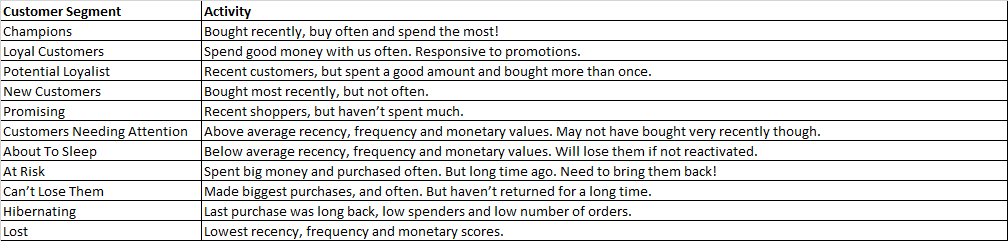

**7.3 Overview of 4 metrics: cust_count,	avg_recency,	avg_frequency,	total_monetary**



**The number of customers by segment**

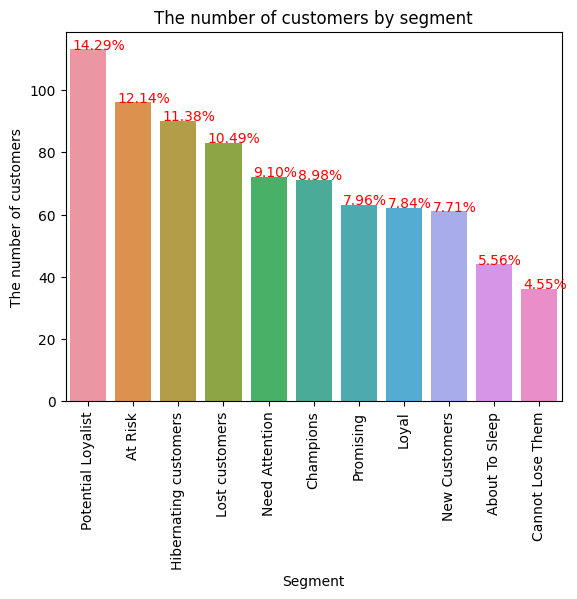

In [ ]:
# Customer count
barchart1 = sns.barplot(data=grp_segment, x='segment', y='cust_count')
plt.xticks(rotation=90)
plt.title('The number of customers by segment')
plt.xlabel('Segment')
plt.ylabel('The number of customers')
values_percent(barchart1)

=> Biểu đồ số lượng khách hàng theo từng phân khúc KH:
- Tỷ lệ Potential Loyalist đứng đầu (14.29%)
- Tỷ lệ khách hành At Risk (12.14%) và Lost customer (10.49%) đang thuộc nhóm cao


**The total of monetary by segment**

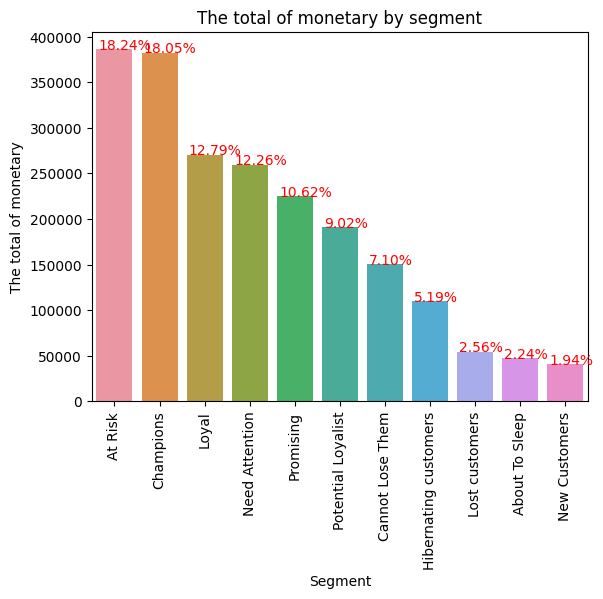

In [ ]:
barchart2 = sns.barplot(data=grp_segment, x='segment', y='total_monetary', order=grp_segment.sort_values('total_monetary', ascending = False).segment)
plt.xticks(rotation=90)
plt.title('The total of monetary by segment')
plt.xlabel('Segment')
plt.ylabel('The total of monetary')
values_percent(barchart2)

=> Biểu đồ tổng giá trị đơn hàng theo từng phân khúc KH
- Có sự chênh lệch lớn giữa trị giá đơn hàng của At Risk 18.24% + khách VIPs 18.05% và các phân khúc còn lại, 2 nhóm KH này đang đứng đầu và áp đảo.
- Kết hợp thêm biểu đồ số lượng KH theo từng phân khúc => Tệp KH At Risk giữ tỷ lệ cao cả về số lượng KH và trị giá đơn hàng => trị giá đơn hàng cao do đặc thù khách hàng ở phân khúc này thường có các đơn hàng trị giá cao tuy nhiên vẫn cần có chương trình nhằm giảm số lượng KH tại phân khúc này và tăng ở phân khúc an toàn hơn



**The average of recency by segment**

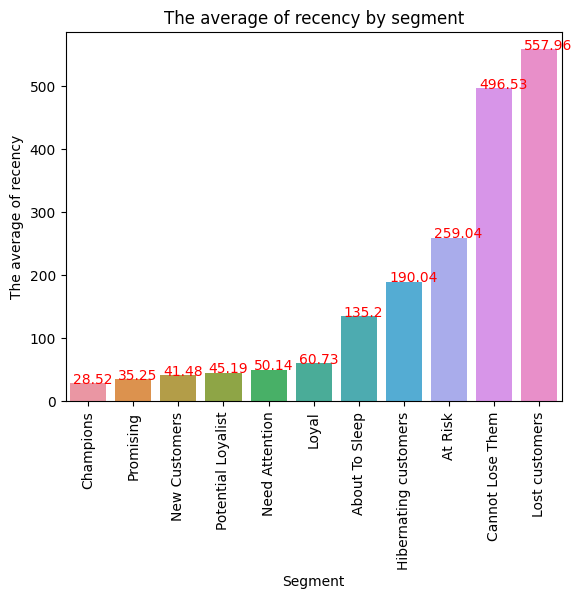

In [ ]:
barchart3 = sns.barplot(data=grp_segment, x='segment', y='avg_recency', order=grp_segment.sort_values('avg_recency').segment)
plt.xticks(rotation=90)
plt.title('The average of recency by segment')
plt.xlabel('Segment')
plt.ylabel('The average of recency')
values(barchart3)

=> Biểu đồ thời điểm mua hàng gần nhất theo từng phân khúc (giá trị trung bình)
- Nhóm KH mua hàng gần đây nhất: VIPs, Promising, New Customers, Potential Loyalist, Need Attention, Loyal (dao động từ 28 đến 60 ngày)
- Trong nhóm KH lâu không mua, có 2 phân khúc cần chú ý bởi họ thường mang đến những đơn hàng giá trị lớn: At Risk (khoảng 259 ngày chưa mua hàng) và Cannot Lose Them (khoảng 496 ngày chưa mua hàng)

**The average of frequency by segment**

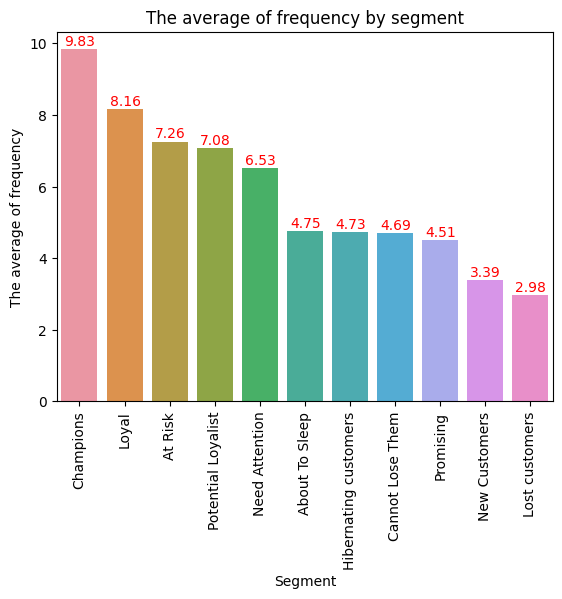

In [ ]:
barchart4 = sns.barplot(data=grp_segment, x='segment', y='avg_frequency', order=grp_segment.sort_values('avg_frequency', ascending = False).segment)
plt.xticks(rotation=90)
plt.title('The average of frequency by segment')
plt.xlabel('Segment')
plt.ylabel('The average of frequency')
values(barchart4)

=> Biểu đồ tần suất mua hàng theo từng phân khúc (giá trị trung bình)
- Các KH thường xuyên mua: VIPs, Loyal, At Risk, Potential Loyalist, Need Attention (trung bình mỗi KH nhóm này đã mua từ 6 -> 10 lần)


**7.4 Channel analysis**

In [ ]:
# Creating table for channel charts
table1 = dim_orders.merge(segmented_rfm[['Customer ID','Segment','monetary']], how = 'left', on = 'Customer ID')
table2 = table1[['Segment','Customer ID', 'Channel', 'monetary']].drop_duplicates()
table2

,Segment,Customer ID,Channel,monetary
0,Loyal,CC-12430,Home Office,2133.180
1,Need Attention,PO-18865,Consumer,2493.214
2,Promising,JM-15580,Consumer,303.948
3,Champions,JG-15160,Consumer,6366.392
4,Need Attention,MC-17845,Consumer,3805.714
...,...,...,...,...
3815,Lost customers,RE-19405,Consumer,48.360
3978,Lost customers,GR-14560,Corporate,1284.380
4089,Lost customers,NB-18580,Corporate,273.872
4288,Lost customers,CR-12625,Home Office,354.120


**Customer number by segment and channel chart**

Text(45.85303124999999, 0.5, 'The number of customers')

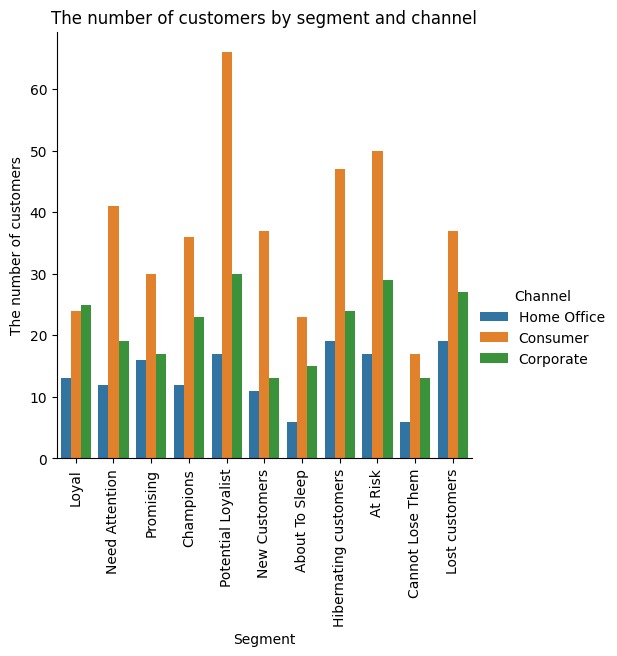

In [ ]:
sns.catplot(data = table2, kind = 'count', x='Segment', hue = 'Channel')
plt.xticks(rotation=90)
plt.title('The number of customers by segment and channel')
plt.xlabel('Segment')
plt.ylabel('The number of customers')

**Sales by segment and channel chart**

Text(50.61740625, 0.5, 'The total sales')

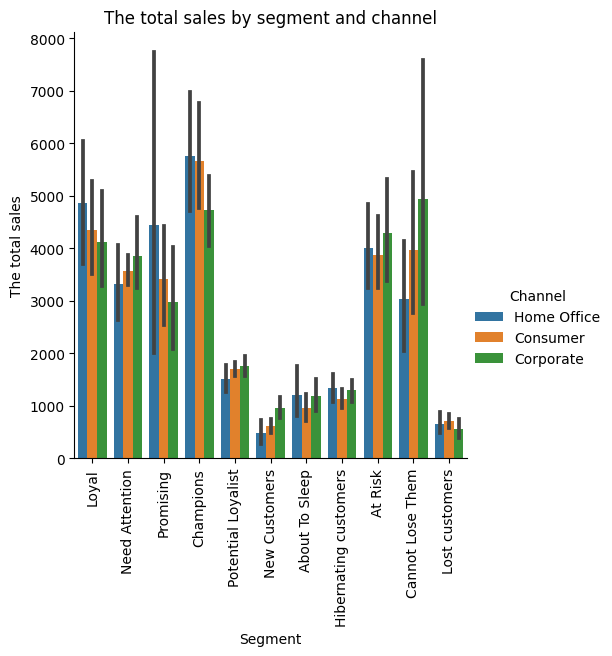

In [ ]:
sns.catplot(data = table2, kind= 'bar', x='Segment', y='monetary', hue = 'Channel')
plt.xticks(rotation=90)
plt.title('The total sales by segment and channel')
plt.xlabel('Segment')
plt.ylabel('The total sales')

=>
- Chênh lệch giữa các nhóm cá nhân, doanh nghiệp trong từng phân khúc không lớn (do khách hàng cá nhân chi tiêu ít nhưng số lượng lớn, ngược lại, KH doanh nghiệp số lượng ít nhưng chi tiêu lớn)

**7.5 Product analysis**

**Creating table for product charts**

In [ ]:
table3 = successful_orders.merge(segmented_rfm[['Customer ID','Segment','monetary']], how = 'left', on = 'Customer ID')
table3 = table3[['Product ID', 'Segment','monetary']].drop_duplicates()
table3 = table3.merge(product[['Product ID', 'Category']], how = 'left', on = 'Product ID')
table3

,Product ID,Segment,monetary,Category
0,OFF-AP-10002457,Loyal,2133.180,Office Supplies
1,FUR-BO-10003441,Need Attention,2493.214,Furniture
2,TEC-PH-10004774,Need Attention,2493.214,Technology
3,OFF-BI-10003684,Need Attention,2493.214,Office Supplies
4,OFF-FA-10003472,Promising,303.948,Office Supplies
...,...,...,...,...
9449,OFF-AR-10003478,Potential Loyalist,1428.231,Office Supplies
9450,OFF-LA-10003223,Lost customers,820.136,Office Supplies
9451,OFF-ST-10002743,Lost customers,820.136,Office Supplies
9452,OFF-BI-10004094,Lost customers,820.136,Office Supplies


**The number of customers by segment and product category chart**

Text(50.74339236111112, 0.5, 'The number of products')

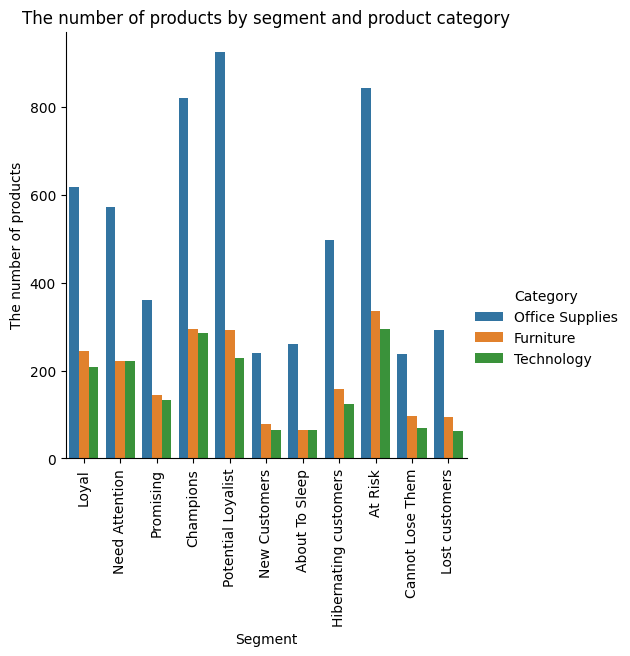

In [ ]:
sns.catplot(data = table3, kind = 'count', x='Segment', hue = 'Category')
plt.xticks(rotation=90)
plt.title('The number of products by segment and product category')
plt.xlabel('Segment')
plt.ylabel('The number of products')

=> Số lượng sản phẩm theo từng phân khúc khách hàng và loại sản phẩm
- Số lượng văn phòng phẩm dẫn đầu (dao động khoảng 250 -> 900 sản phẩm/phân khúc, do đặc thù số lượng lớn về loại và số sản phẩm)
- Số lượng sản phẩm bán được nhóm ngành công nghệ thấp hơn nội thất nhưng mức chênh lệnh nhỏ (cao nhất khoảng 50 sản phẩm/ phân khúc)
- Các phân khúc KH bán được nhiều sản phẩm nhất: Potential loyalist, VIPs, At Risk, Loyal.

**The total sales by segment and product category**

Text(53.43620486111111, 0.5, 'The total sales')

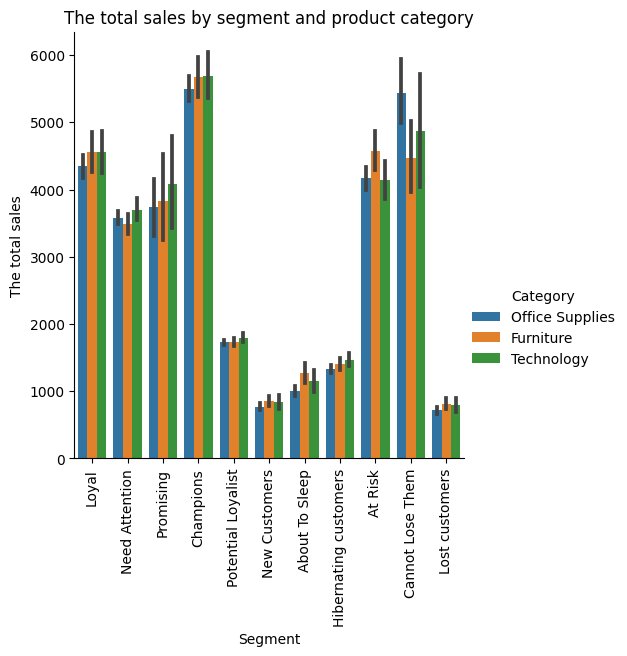

In [ ]:
sns.catplot(data = table3, kind = 'bar', x='Segment', y='monetary', hue = 'Category')
plt.xticks(rotation=90)
plt.title('The total sales by segment and product category')
plt.xlabel('Segment')
plt.ylabel('The total sales')

=> Giá trị đơn hàng theo phân khúc KH và loại sản phẩm
- Trong từng phân khúc KH, không có sự cách biệt quá lớn về giá trị đơn hàng, chỉ có phân khúc "Cannot Lose Them" đang có giá trị văn phòng phẩm lớn hơn 2 nhóm ngành còn lại gần 1000 USD
- At risk và About to sleep là 2 phân khúc có giá trị các đơn hàng nội thất cao hơn các nhóm còn lại nhưng không đáng kể (hơn khoảng 100 USD)
- Tại các nhóm khách hàng còn lại, các sản phẩm công nghệ đều mang lại giá trị đơn hàng cao nhất

**7.6 Region analysis**



In [ ]:
table4 = table1[['Customer ID', 'Postal Code', 'Segment','monetary']].drop_duplicates()
table4 = table4.merge(location[['Postal Code', 'Region']], how = 'left', on = 'Postal Code')
table4

,Customer ID,Postal Code,Segment,monetary,Region
0,CC-12430,47201,Loyal,2133.180,Central
1,PO-18865,10009,Need Attention,2493.214,East
2,JM-15580,80538,Promising,303.948,West
3,JG-15160,90049,Champions,6366.392,West
4,MC-17845,10035,Need Attention,3805.714,East
...,...,...,...,...,...
4641,JO-15145,30605,Champions,3254.949,South
4642,ME-17320,42420,Champions,10663.728,South
4643,MB-18085,19143,Potential Loyalist,1428.231,East
4644,PO-19195,60540,Lost customers,820.136,Central


**The number of customers by segment and region**

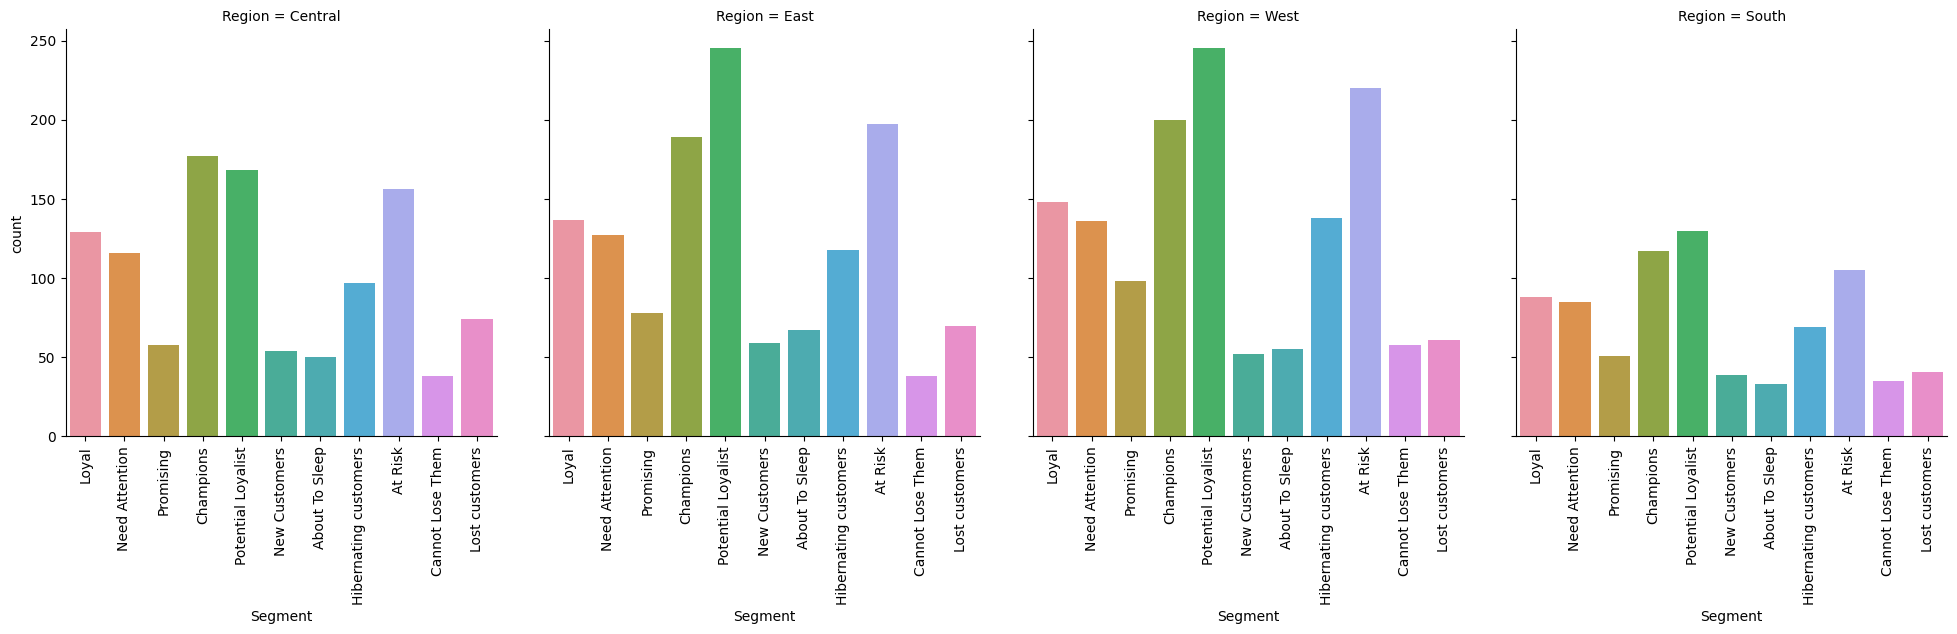

In [ ]:
chart = sns.catplot(data = table4, kind = 'count', x = 'Segment', col = 'Region', col_wrap=4)
plt.xlabel('Segment')
for ax in chart.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

=> Số lượng khách theo phân khúc và khu vực địa lý
- Tổng lượng khách tại khu vực phía Đông và Tây cao hơn khu trung tâm và phía Nam
- Các khách VIPs gần bằng nhau giữa 3 khu vực: trung tâm, đông và tây (dao động khoảng 180-200 khách trong khi phía Nam chỉ khoảng 120)
Khách hàng trung thành và nhóm Need Attention tương tự: Loyal dao động 130-150 khách trong khi phía Nam chỉ khoảng 80; Need Attention dao động 120-140 trong khi phía Nam chỉ khoảng 75
- Khách hàng tiềm năng (potential loyalist) cao nhất tại 2 khu vực Đông và Tây (khoảng 240 khách)
- Nhóm KH At risk cũng cao nhất tại 2 khu vực Đông, Tây (dao động 200-230 khách)
- Các phân khúc còn lại số lượng ít hơn và chênh lệch giữa các khu vực không đáng kể

*Giải thích:
- Bờ Đông và Tây là 2 khu vực tập trung nhiều thành phố lớn và mật độ dân cư đông nhất nước Mỹ, đông đúc hơn so với khu trung tâm và phía Nam, do đó các chỉ số về số lượng KH/ sức mua sẽ có sự chênh lệch như đã nói phía trên

**The total sales by segment and region**

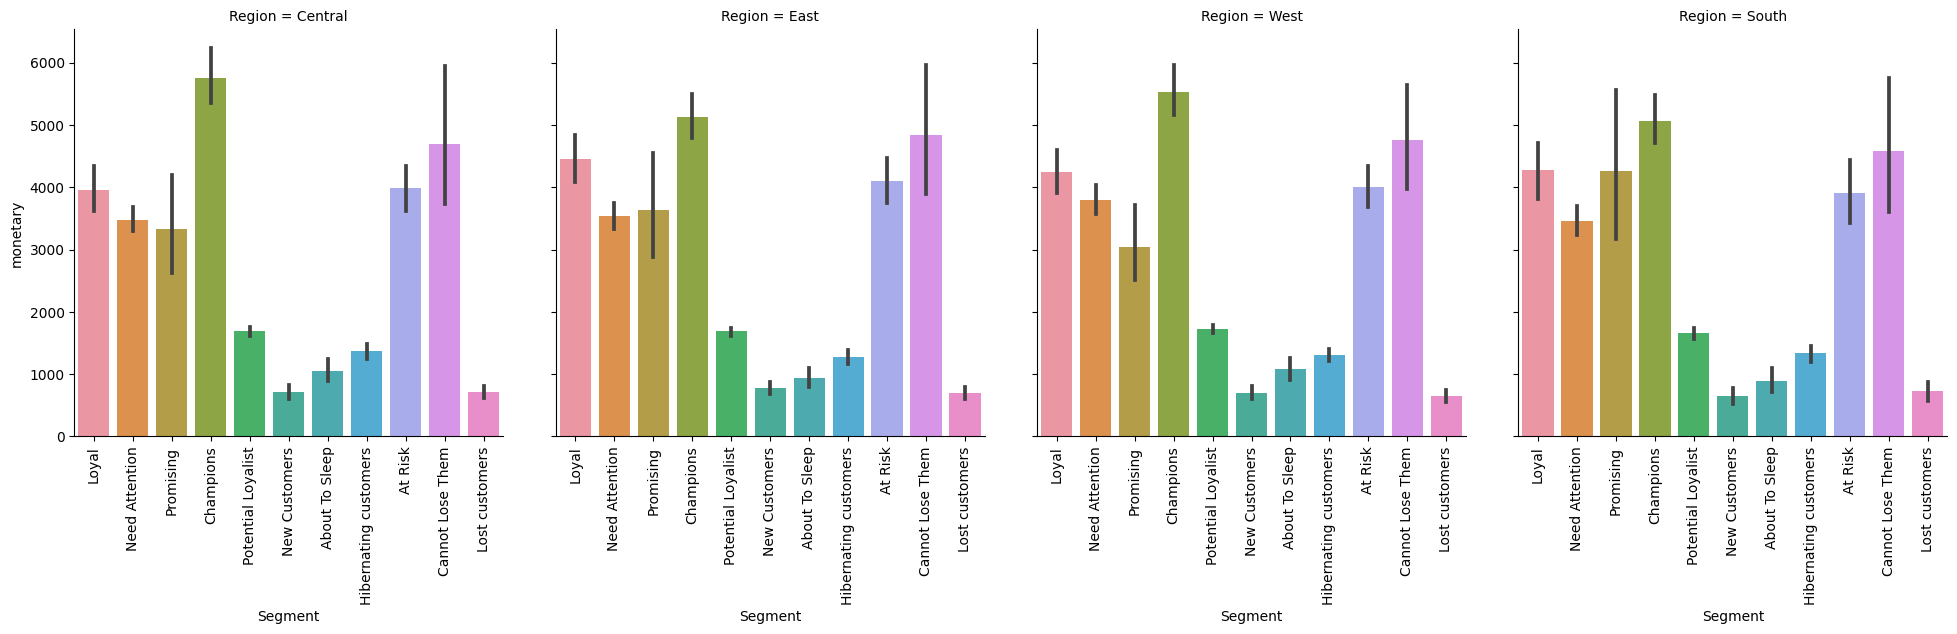

In [ ]:
chart = sns.catplot(data = table4, kind = 'bar', x = 'Segment', y ='monetary', col = 'Region', col_wrap=4)
for ax in chart.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

=> Trị giá đơn hàng theo phân khúc KH và khu vực địa lý
- Dù có chênh lệch về số lượng KH giữa khu vực bờ Đông, Tây với khu Trung tâm và phía Nam nhưng tổng trị giá đơn hàng không cho thấy sự chênh lệch quá lớn
=> Từ đây có thể thấy trị giá đơn hàng trung bình/mỗi KH tại 2 khu vực: trung tâm và phía Nam cao hơn 2 khu vực còn lại

**7.7 Overtime analysis**

In [ ]:
table5 = successful_orders[['Customer ID', 'Order Date']].drop_duplicates()
table5['year'] = table5['Order Date'].dt.year
table5['quarter'] = table5['Order Date'].dt.quarter
table6 = table5.merge(segmented_rfm[['Customer ID', 'Segment', 'monetary']], how = 'left', on = 'Customer ID')
table6

,Customer ID,Order Date,year,quarter,Segment,monetary
0,CC-12430,2017-12-30,2017,4,Loyal,2133.180
1,PO-18865,2017-12-30,2017,4,Need Attention,2493.214
2,JM-15580,2017-12-30,2017,4,Promising,303.948
3,JG-15160,2017-12-29,2017,4,Champions,6366.392
4,MC-17845,2017-12-29,2017,4,Need Attention,3805.714
...,...,...,...,...,...,...
4694,JO-15145,2014-01-06,2014,1,Champions,3254.949
4695,ME-17320,2014-01-06,2014,1,Champions,10663.728
4696,MB-18085,2014-01-05,2014,1,Potential Loyalist,1428.231
4697,PO-19195,2014-01-04,2014,1,Lost customers,820.136


**The total sales by segment over year**

Text(62.07125694444444, 0.5, 'The total sales')

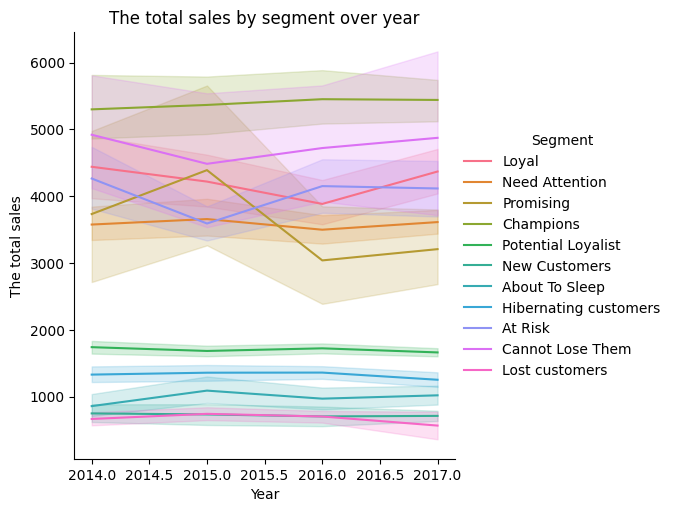

In [ ]:
sns.relplot(
    data=table6, x="year", y="monetary",
    hue="Segment", kind="line"
)
plt.title('The total sales by segment over year')
plt.xlabel('Year')
plt.ylabel('The total sales')

- Các phân khúc hầu như không biến động theo năm: VIPs, Potential Loyalist, New customers, About to sleep, Hibernating customers, Lost customers
- Các phân khúc có xu hướng tăng lên vào 2015 và giảm xuống vào 2016 theo đồ thị hình sin: Promising, Need Attention
- Các phân khúc có xu hướng giảm vào 2015 và tăng lên vào 2016 theo đồ thị hình sin: At risk, Cannot lose them
- Nhóm Loyal giảm từ 2014 -> 2016 rồi lại tăng lên vào 2017

**The total sales by segment over quarter**

Text(62.07125694444444, 0.5, 'The total sales')

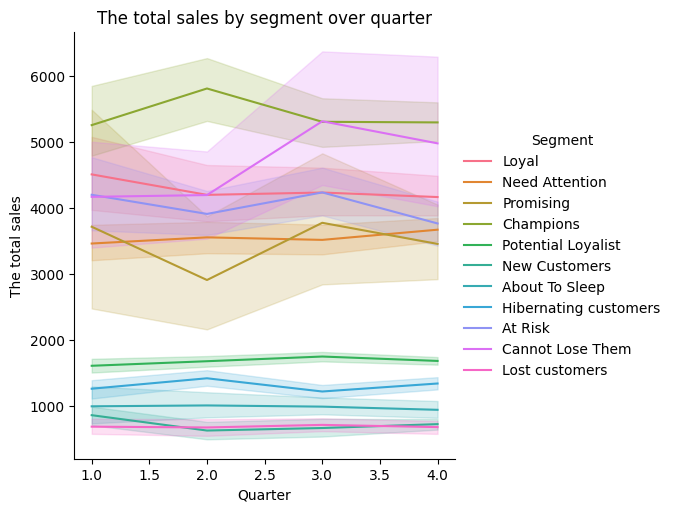

In [ ]:
sns.relplot(
    data=table6, x="quarter", y="monetary",
    hue="Segment", kind="line"
)
plt.title('The total sales by segment over quarter')
plt.xlabel('Quarter')
plt.ylabel('The total sales')

=> Các nhóm khách hàng không có sự biến động mạnh về chi tiêu theo từng quý bao gồm:
- Loyal, Need Attention, Potential Loyalist, New customers, About to sleep, Hibernating customers, Lost customers
- Chi tiêu của khách VIPs có xu hướng tăng vào quý 2 và giảm dần về cuối năm
- Nhóm KH có xu hướng giảm chi tiêu vào quý 2 và tăng dần về cuối năm: Promising, At risk, Cannot lose them


**8.RECOMMENDATION**

**8.1 Recommendation for segments**

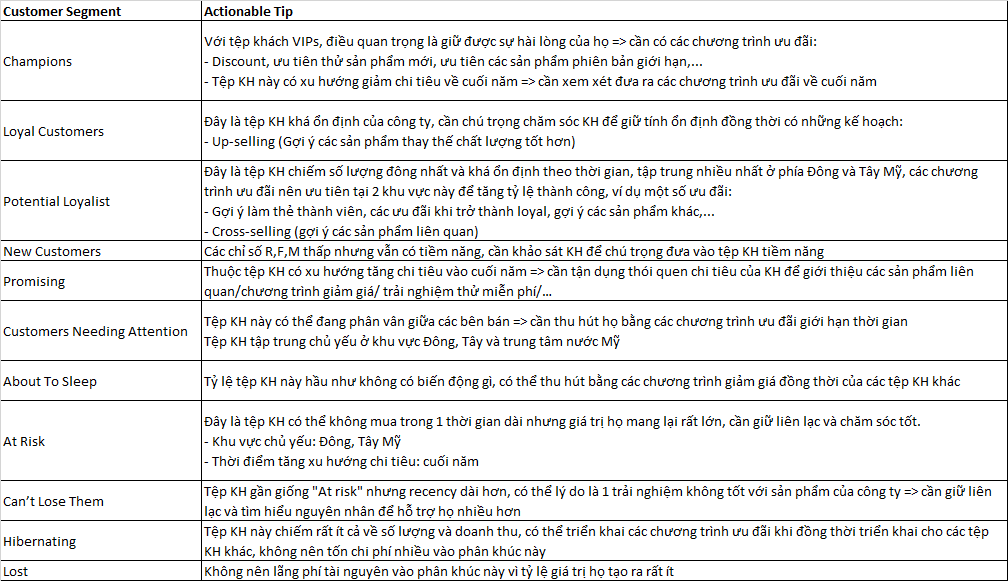

**8.2 Recommendations about R,F,M:**
- Theo các đề xuất về kế hoạch cho từng phân khúc đã nói trên kết hợp với phân tích từ các biểu đồ trực quan => thứ tự quan trọng giảm dần của 3 chỉ số:
Monetary > Frequency > Recency